In [162]:
import pandas as pd
from pathlib import Path
import duckdb

In [163]:
DATA_FILE=Path(".", "tests", "BCCaseFileUploading.xlsx")
df = pd.read_excel(DATA_FILE)

Two methods of data transformations are used in this notebook:

1. Using Pandas API and methods
2. Using Duckdb Python API to write queries simulating SQL

### Pandas API  
  

Pandas dataframe is similar to a named dataset in SAS. Data manipulations are performed to convert the initial data to a new dataframe (dataset).

**Renaming Columns**: When creating a new dataframe, the new column name is assigned a specific column from the old dataframe.  
**Data Transformation**: Similar to calculations or changes to field values done by the case statements, some operations are performed by [apply](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) and [map](https://pandas.pydata.org/docs/dev/reference/api/pandas.DataFrame.map.html). 

*Map*: is used to apply a function or a dictionary to a column of the dataframe. If a method is passed, the definition is executed for every row cell of that column and a dictionary maps values to the expected resultant values.   
  
*Apply*: The apply function can be used to execute a custom function for each row or column of the dataframe. `axis` is used to determine if the function is to be applied to the row or column. In the below example, since axis is set to 1, the lambda function is applied to each row of the dataframe. For instance, we introduce a new column `Initial_Resistance` with numeric values based on multiple fields - classification and other resistance fields.  
  
**Missing values**: Some of the else conditions in the proc SQL statements can be executed by filling missing values in the column with a value of our choice using [`fillna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html). This works through the dataframe of only the specific columns we choose.

In [164]:
bc_1 = pd.DataFrame({
    'RegisterCaseNumber': df['client_id_phac'],
    'DiagnosisDate': df['classification_date'],
    'Survey_Year': df['classification_year'],
    'CaseCriteria': df['classification'].map({'Clinical': 2, 'Confirmed': 1}),
    'Initial_Resistance': df.apply(lambda row: 
                                   1 if row['classification'] == 'Confirmed' and (
        'R' in [row['isoniazid_resistance'], row['ethambutol_resistance'], row['rifampin_resistance'], row['pyrazinamide_resistance']])
        else 2 if row['classification'] == 'Confirmed' and ('S' in [row['isoniazid_resistance'], row['ethambutol_resistance'], row['rifampin_resistance'], row['pyrazinamide_resistance']])
        else 9 if row['classification'] == 'Confirmed' else None, axis=1),
    'IR_INH': df['isoniazid_resistance'].map({'R': 'Resistant', 'S': 'Susceptible'}).fillna('Not Done'),
    'IR_EMB': df['ethambutol_resistance'].map({'R': 'Resistant', 'S': 'Susceptible'}).fillna('Not Done'),
    'IR_RMP': df['rifampin_resistance'].map({'R': 'Resistant', 'S': 'Susceptible'}).fillna('Not Done'),
    'IR_PZA': df['pyrazinamide_resistance'].map({'R': 'Resistant', 'S': 'Susceptible'}).fillna('Not Done'),
    'IR_Amikacin': df['amikacin_resistance'].map({'R': 'Resistant', 'S': 'Susceptible'}).fillna('Not Done'),
    'IR_Capreomycin': df['capreomycin_resistance'].map({'R': 'Resistant', 'S': 'Susceptible'}).fillna('Not Done'),
    'IR_Ethionamide': df['ethionamide_resistance'].map({'R': 'Resistant', 'S': 'Susceptible'}).fillna('Not Done'),
    'IR_Kanamycin': df['kanamycin_resistance'].map({'R': 'Resistant', 'S': 'Susceptible'}).fillna('Not Done'),
    'IR_Moxifloxacin': df['moxifloxacin_resistance'].map({'R': 'Resistant', 'S': 'Susceptible'}).fillna('Not Done'),
    'IR_Ofloxacin': df['ofloxacin_resistance'].map({'R': 'Resistant', 'S': 'Susceptible'}).fillna('Not Done'),
    'IR_Other': df['linezolid_resistance'].map({'R': 'Resistant', 'S': 'Susceptible'}).fillna('Not Done'),
    'IR_Other_Drug': df.apply(lambda row: 'Linezolid' if pd.notna(row['linezolid_resistance']) else None, axis=1),
    'IR_PAS': df['para_aminosalicylate_resistance'].map({'R': 'Resistant', 'S': 'Susceptible'}).fillna('Not Done'),
    'IR_Rifabutin': df['rifabutin_resistance'].map({'R': 'Resistant', 'S': 'Susceptible'}).fillna('Not Done'),
    'IR_SM': df['streptomycin_resistance'].map({'R': 'Resistant', 'S': 'Susceptible'}).fillna('Not Done'),
    'IR_Gatifloxacin': '',
    'IR_Levofloxacin': '',
    'IR_Ciprofloxacin': '',
    'IR_Clarithromycin': '',
    'IR_Clofazamine': '',
    'IR_Cycloserine': '',
    'IR_Pyridoxine': '',
    'IR_Rifapentine': '',
    'IR_Unknown': '',
    'Age': df['age_at_classification_date_years'],
    'Gender': df['gender'].map({'Male': 'M', 'Female': 'F'}),
    'Origin': df['origin'].map({'Canadian Born': 8, 'Foreign Born': 6}).fillna(9),
    'Country_Of_Birth': df['origin'].map({
        'Canadian Born': 'Canada',
        'Foreign Born': df['country_of_birth_combined'].map({
            'Taiwan': 'Taiwan (Province Of China)',
            'Iran, Islamic Republic of': 'Iran',
        }).fillna("Unknown")
    }),
    'DateOfArrival': pd.to_datetime(df['immigration_arrival_date_combine'], format='%y%m%d').dt.date,
    'Immigration_Status': df['immigration_status_combined'].map({
        'Foreign-born Canadian Citizen': 1,
        'Permanent Resident': 1,
        'Refugee Claimant': 2,
        'Student Permit': 6,
        'Visitor': 7,
        'Work Permit': 5,
        'Other Current Immigration Status': 8,
        'Unknown': 9
    }).fillna(9),
    'OtherImmigStatus': df['immigration_status_combined'].apply(lambda x: 'Not Specified' if x == 'Other Current Immigration Status' else ''),
    'CaseFinding': df['method_of_detection'].map({
        'Symptoms compatible with site of disease': 1,
        'Incidental finding': 2,
        'Post-mortem': 3,
        'Contact investigation': 4,
        'Immigration medical surveillance': 5,
        'Other Screening': 8,
        'Other': 9,
        'Unknown': 10
    }).fillna(10),
    'CaseFindingOther': df['method_of_detection'].apply(lambda x: 'Not specified' if x == 'Other' else ''),
    'Case_Comment': df['tb_body_site_category_phac'],
    'PrevAbnormalChestXRay': df['previous_abnormal_chest_xray'].map({'Yes': 1, 'No': 2}).fillna(9),
    'TBContact2Years': df['tb_contact_within_2_years'].map({'Yes': 1, 'No': 2}).fillna(9),
    'Diabetes': df['diabetes_mellitus'].map({'Yes': 1, 'No': 2}).fillna(9),
    'ChronicRenalFailure': df['kidney_disease_requiring_dialysi'].map({'Yes': 1, 'No': 2}).fillna(9),
    'Homeless': df['homelessness'].map({'Yes': 1, 'No': 2}).fillna(9),
    'LTCorticosteroidUse': df['longterm_corticosteriod_use'].map({'Yes': 1, 'No': 2}).fillna(9),
    'KnownSuspSubstanceAbuse': df['injection_drug_use'].map({'Yes': 1, 'No': 2}).fillna(9),
    'Transplant': df['solid_organ_transplant_candidate'].map({'Yes': 1, 'No': 2}).fillna(9),
    'HIVStatus': df['hiv_status'].fillna('Unknown'),
    'Date_Of_HIV_Test': df['hiv_status'].map(lambda x: '9999/99/99' if x in ['Positive', 'Negative'] else None),
    'LiveCorrectionSetting': '',
    'TravelTBCountry': '',
    'Howlong': '',
    'OtherRiskFactors': df.apply(
        lambda row: 'alcohol and tobacco use' if row['alcohol_use'] == 'Yes' and row['tobacco_use'] == 'Yes'
        else ('alcohol use' if row['alcohol_use'] == 'Yes'
              else ('tobacco use' if row['tobacco_use'] == 'Yes' else '')), axis=1),
    'rownumber': range(1, len(df) + 1)
})

bc_1.to_csv('bc_1.csv', index=False)


### BC CaseFileUploading

### DuckDB  
  
Data transformations and manipulation can be performed by writing SQL queries and executing them on dataframes using the [duckdb Python API](https://duckdb.org/docs/api/python/overview.html). 

In [165]:
SQL_QUERY = """SELECT
    client_id_phac AS RegisterCaseNumber,
    classification_date AS DiagnosisDate,
    classification_year AS Survey_Year,
    CASE
        WHEN lower(classification) = 'clinical' THEN 2
        WHEN lower(classification) = 'confirmed' THEN 1
    END AS CaseCriteria,
    CASE
        WHEN classification = 'Confirmed' AND
            (isoniazid_resistance LIKE 'R'
            OR ethambutol_resistance LIKE 'R'
            OR rifampin_resistance LIKE 'R'
            OR pyrazinamide_resistance LIKE 'R') THEN 1
        WHEN classification = 'Confirmed' AND
            (isoniazid_resistance LIKE 'S'
            OR ethambutol_resistance LIKE 'S'
            OR rifampin_resistance LIKE 'S'
            OR pyrazinamide_resistance LIKE 'S') THEN 2
        WHEN classification = 'Confirmed' AND
            (isoniazid_resistance IS NULL
            AND ethambutol_resistance IS NULL
            AND rifampin_resistance IS NULL
            AND pyrazinamide_resistance IS NULL) THEN 9
    END AS Initial_Resistance,
    CASE
        WHEN isoniazid_resistance LIKE 'R' THEN 'Resistant'
        WHEN isoniazid_resistance LIKE 'S' THEN 'Susceptible'
        ELSE 'Not Done'
    END AS IR_INH,
    CASE
        WHEN ethambutol_resistance LIKE 'R' THEN 'Resistant'
        WHEN ethambutol_resistance LIKE 'S' THEN 'Susceptible'
        ELSE 'Not Done'
    END AS IR_EMB,
    CASE
        WHEN rifampin_resistance LIKE 'R' THEN 'Resistant'
        WHEN rifampin_resistance LIKE 'S' THEN 'Susceptible'
        ELSE 'Not Done'
    END AS IR_RMP,
    CASE
        WHEN pyrazinamide_resistance LIKE 'R' THEN 'Resistant'
        WHEN pyrazinamide_resistance LIKE 'S' THEN 'Susceptible'
        ELSE 'Not Done'
    END AS IR_PZA,
    CASE
        WHEN amikacin_resistance LIKE 'R' THEN 'Resistant'
        WHEN amikacin_resistance LIKE 'S' THEN 'Susceptible'
        ELSE 'Not Done'
    END AS IR_Amikacin,
    CASE
        WHEN capreomycin_resistance LIKE 'R' THEN 'Resistant'
        WHEN capreomycin_resistance LIKE 'S' THEN 'Susceptible'
        ELSE 'Not Done'
    END AS IR_Capreomycin,
    CASE
        WHEN ethionamide_resistance LIKE 'R' THEN 'Resistant'
        WHEN ethionamide_resistance LIKE 'S' THEN 'Susceptible'
        ELSE 'Not Done'
    END AS IR_Ethionamide,
    CASE
        WHEN kanamycin_resistance LIKE 'R' THEN 'Resistant'
        WHEN kanamycin_resistance LIKE 'S' THEN 'Susceptible'
        ELSE 'Not Done'
    END AS IR_Kanamycin,
    CASE
        WHEN moxifloxacin_resistance LIKE 'R' THEN 'Resistant'
        WHEN moxifloxacin_resistance LIKE 'S' THEN 'Susceptible'
        ELSE 'Not Done'
    END AS IR_Moxifloxacin,
    CASE
        WHEN ofloxacin_resistance LIKE 'R' THEN 'Resistant'
        WHEN ofloxacin_resistance LIKE 'S' THEN 'Susceptible'
        ELSE 'Not Done'
    END AS IR_Ofloxacin,
    CASE
        WHEN linezolid_resistance LIKE 'R' THEN 'Resistant'
        WHEN linezolid_resistance LIKE 'S' THEN 'Susceptible'
        ELSE 'Not Done'
    END AS IR_Other,
    CASE
        WHEN linezolid_resistance IS NOT NULL THEN 'Linezolid'
    END AS IR_Other_Drug,
    CASE
        WHEN para_aminosalicylate_resistance LIKE 'R' THEN 'Resistant'
        WHEN para_aminosalicylate_resistance LIKE 'S' THEN 'Susceptible'
        ELSE 'Not Done'
    END AS IR_PAS,
    CASE
        WHEN rifabutin_resistance LIKE 'R' THEN 'Resistant'
        WHEN rifabutin_resistance LIKE 'S' THEN 'Susceptible'
        ELSE 'Not Done'
    END AS IR_Rifabutin,
    CASE
        WHEN streptomycin_resistance LIKE 'R' THEN 'Resistant'
        WHEN streptomycin_resistance LIKE 'S' THEN 'Susceptible'
        ELSE 'Not Done'
    END AS IR_SM,
    '' AS IR_Gatifloxacin,
    '' AS IR_Levofloxacin ,
    '' AS IR_Ciprofloxacin ,
    '' AS IR_Clarithromycin,
    '' AS IR_Clofazamine ,
    '' AS IR_Cycloserine ,
    '' AS IR_Pyridoxine ,
    '' AS IR_Rifapentine ,
    '' AS IR_Unknown ,
    age_at_classification_date_years AS Age,
    CASE
        WHEN gender LIKE 'Male' THEN 'M'
        WHEN gender LIKE 'Female' THEN 'F'
    END AS Gender,
    CASE
        WHEN origin = 'Canadian Born' THEN 8
        WHEN origin = 'Foreign Born' THEN 6
        ELSE 9
    END AS Origin,
    CASE
        WHEN origin = 'Canadian Born' THEN 'Canada'
        WHEN (origin = 'Foreign Born' AND country_of_birth_combined LIKE 'Taiwan') THEN 'Taiwan (Province Of China)'
        WHEN (origin = 'Foreign Born' AND country_of_birth_combined LIKE 'Iran, Islamic Republic of') THEN 'Iran'
        WHEN (origin = 'Foreign Born' AND country_of_birth_combined Like '%Korea%') THEN 'Rep. Korea (South Korea)'
        WHEN (origin = 'Foreign Born' AND country_of_birth_combined LIKE 'Macao') THEN 'China, Macao SAR'
        WHEN (origin = 'Foreign Born' AND country_of_birth_combined LIKE 'Syrian Arab Republic') THEN 'Syrian Arab Republic (Syria)'
        WHEN (origin = 'Foreign Born' AND country_of_birth_combined LIKE 'Hong Kong') THEN 'China, Hong Kong SAR'
        WHEN (origin = 'Foreign Born' AND country_of_birth_combined LIKE 'Tibet') THEN 'Tibet (China)'
        WHEN (origin = 'Foreign Born' AND country_of_birth_combined IS NULL) THEN 'Unknown'
        ELSE country_of_birth_combined
    END AS Country_Of_Birth,
    immigration_arrival_date_combine AS DateOfArrival,
    CASE
        WHEN origin = 'Foreign Born' AND immigration_status_combined IS NULL THEN 9
        WHEN immigration_status_combined = 'Foreign-born Canadian Citizen' THEN 1
        WHEN immigration_status_combined = 'Permanent Resident' THEN 1
        WHEN immigration_status_combined = 'Refugee Claimant' THEN 2
        WHEN immigration_status_combined = 'Student Permit' THEN 6
        WHEN immigration_status_combined = 'Visitor' THEN 7
        WHEN immigration_status_combined = 'Work Permit' THEN 5
        WHEN immigration_status_combined = 'Other Current Immigration Status' THEN 8
        WHEN immigration_status_combined = 'Unknown' THEN 9
    END AS Immigration_Status,
    CASE
        WHEN immigration_status_combined = 'Other Current Immigration Status' THEN 'Not Specified'
        ELSE ''
    END AS OtherImmigStatus,
    CASE
        WHEN method_of_detection = 'Symptoms compatible with site of disease' THEN 1
        WHEN method_of_detection = 'Incidental finding' THEN 2
        WHEN method_of_detection = 'Post-mortem' THEN 3
        WHEN method_of_detection = 'Contact investigation' THEN 4
        WHEN method_of_detection = 'Immigration medical surveillance' THEN 5
        WHEN method_of_detection = 'Other Screening' THEN 8
        WHEN method_of_detection = 'Other' THEN 9
        WHEN method_of_detection = 'Unknown' THEN 10
        WHEN origin = 'Foreign Born' AND method_of_detection IS NULL THEN 10
    END AS CaseFinding,
    CASE
        WHEN method_of_detection = 'Other' THEN 'Not specified'
        ELSE ''
    END AS CaseFindingOther,
    tb_body_site_category_phac AS Case_Comment,
    CASE
        WHEN previous_abnormal_chest_xray LIKE 'Yes' THEN 1
        WHEN previous_abnormal_chest_xray LIKE 'No' THEN 2
        ELSE 9
    END AS PrevAbnormalChestXRay,
    CASE
        WHEN tb_contact_within_2_years LIKE 'Yes' THEN 1
        WHEN tb_contact_within_2_years LIKE 'No' THEN 2
        ELSE 9
    END AS TBContact2Years,
    CASE
        WHEN diabetes_mellitus like '%Yes%' THEN 1
        WHEN diabetes_mellitus like '%No%' THEN 2
        ELSE 9
    END AS Diabetes,
    CASE
        WHEN kidney_disease_requiring_dialysi like '%Yes%' THEN 1
        WHEN kidney_disease_requiring_dialysi like '%No%' THEN 2
        ELSE 9
    END AS ChronicRenalFailure,
    CASE
        WHEN homelessness like '%Yes%' THEN 1
        WHEN homelessness like '%No%' THEN 2
        ELSE 9
    END AS Homeless,
    CASE
        WHEN longterm_corticosteriod_use like '%Yes%' THEN 1
        WHEN longterm_corticosteriod_use like '%No%' THEN 2
        ELSE 9
    END AS LTCorticosteroidUse,
    CASE
        WHEN injection_drug_use like '%Yes%' THEN 1
        WHEN injection_drug_use like '%No%' THEN 2
        ELSE 9
    END AS KnownSuspSubstanceAbuse,
    CASE
        WHEN solid_organ_transplant_candidate like '%Yes%' THEN 1
        WHEN solid_organ_transplant_candidate like '%No%' THEN 2
        ELSE 9
    END AS Transplant,
    CASE
        WHEN hiv_status IS NULL THEN 'Unknown'
        ELSE hiv_status
    END AS HIVStatus,
    CASE
        WHEN hiv_status LIKE 'Positive' OR hiv_status LIKE 'Negative' THEN '9999/99/99'
    END AS Date_Of_HIV_Test,
    '' AS LiveCorrectionSetting,
    '' AS TravelTBCountry,
    '' AS Howlong,
    CASE
        WHEN alcohol_use LIKE 'Yes' AND tobacco_use LIKE 'Yes' THEN 'alcohol and tobacco use'
        WHEN alcohol_use LIKE 'Yes' THEN 'alcohol use'
        WHEN tobacco_use LIKE 'Yes' THEN 'tobacco use'
    END AS OtherRiskFactors,
    ROW_NUMBER() OVER (ORDER BY client_id_phac) AS rownumber
FROM df
"""

In [166]:
result = duckdb.sql(SQL_QUERY).to_df()

The below code has the SQL query executed using the Pandas API to segment the row to various buckets of age groups using the [`cut`](https://pandas.pydata.org/docs/reference/api/pandas.cut.html). The arguments to cut used are:  

*data*: The data to be segmented - the age column.  
*bins*: The edges that determine the boundary of each bin. Here [-1, 1, 5, 15, 25, 35, 45, 55, 65, 75, 120] means the bins are: (-1 to <1, 1 to <5 and so on).  
*labels*: The different categories to identify.  

In [167]:
SQL_QUERY = """SELECT 
    *, 
    CASE 
        WHEN AGE >= -1 AND AGE < 1 THEN 1 
        WHEN AGE >= 1 AND AGE < 5 THEN 2 
        WHEN AGE >= 5 AND AGE < 15 THEN 3 
        WHEN AGE >= 15 AND AGE < 25 THEN 4 
        WHEN AGE >= 25 AND AGE < 35 THEN 5 
        WHEN AGE >= 35 AND AGE < 45 THEN 6 
        WHEN AGE >= 45 AND AGE < 55 THEN 7 
        WHEN AGE >= 55 AND AGE < 65 THEN 8 
        WHEN AGE >= 65 AND AGE < 75 THEN 9 
        WHEN AGE >= 75 AND AGE < 120 THEN 10 
        ELSE 99 
    END AS AgeGroup, 
    CASE 
        WHEN survey_year IS NOT NULL THEN survey_year || '-' || RegisterCaseNumber 
    END AS Subject_Code 
FROM result; 
"""

result['AgeGroup'] = pd.cut(result['Age'],
    bins=[-1, 1, 5, 15, 25, 35, 45, 55, 65, 75, 120],
    labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    include_lowest=True
)
result['Subject_Code'] = result.apply(
    lambda row: f"{row['Survey_Year']}-{row['RegisterCaseNumber']}" if not pd.isnull(row['Survey_Year']) else None,
    axis=1
)

In [168]:
SQL_QUERY = """SELECT
    RegisterCaseNumber,
    Subject_Code,
    'British Columbia' AS ReportingProvince,
    '9999/99/99' AS Date_Of_Birth,
    Gender,
    Age,
    AgeGroup,
    '' AS City,
    '' AS Health_Unit,
    'Z9Z' AS PostalCode,
    Origin,
    '' AS Place_Lived,
    '' AS Other_Aboriginal,
    '' AS COBMother,
    '' AS COBFather,
    Country_Of_Birth,
    DateOfArrival,
    Immigration_Status,
    OtherImmigStatus,
    'Active' AS Subject_Status,
    Survey_Year,
    DiagnosisDate,
    '' AS ICDOption,
    '' AS ICD9,
    '' AS ICD10,
    '' AS Diagnostics_Site,
    '' AS ChestXRay,
    '' AS IfAbnormal,
    '' AS M_Sputum,
    '' AS M_BronchialWash,
    '' AS M_GIWash,
    '' AS M_NodeBiopsy,
    '' AS M_Urine,
    '' AS M_CSF,
    '' AS M_Other,
    '' AS C_Sputum,
    '' AS C_BronchialWash,
    '' AS C_GIWash,
    '' AS C_NodeBiopsy,
    '' AS C_Urine,
    '' AS C_CSF,
    '' AS C_Other,
    '' AS BS_Microscopy,
    '' AS BS_Culture,
    CaseCriteria,
    Initial_Resistance,
    IR_INH,
    IR_EMB,
    IR_RMP,
    IR_PZA,
    IR_Amikacin,
    IR_Capreomycin,
    IR_Ciprofloxacin,
    IR_Clarithromycin,
    IR_Clofazamine,
    IR_Cycloserine,
    IR_Ethionamide,
    IR_Gatifloxacin,
    IR_Kanamycin,
    IR_Levofloxacin,
    IR_Moxifloxacin,
    IR_Ofloxacin,
    IR_Other,
    IR_PAS,
    IR_Pyridoxine,
    IR_Rifabutin,
    IR_Rifapentine,
    IR_SM,
    IR_Other_Drug,
    '' AS GenotypingResults,
    '' AS GenotypingSpoligotyping,
    '' AS MIRU,
    NULL AS RFLP,
    '' AS DateTreatmentStarted,
    '' AS DP_INH,
    '' AS DP_EMB,
    '' AS DP_RMP,
    '' AS DP_PZA,
    NULL AS DP_Amikacin,
    NULL AS DP_Capreomycin,
    NULL AS DP_Ciprofloxacin,
    NULL AS DP_Clarithromycin,
    NULL AS DP_Clofazamine,
    NULL AS DP_Cycloserine,
    NULL AS DP_Ethionamide,
    NULL AS DP_Gatifloxacin,
    NULL AS DP_Kanamycin,
    NULL AS DP_Levofloxacin,
    NULL AS DP_Moxifloxacin,
    NULL AS DP_NoDrugsPrescribed,
    NULL AS DP_Ofloxacin,
    '1' AS DP_Other,
    NULL AS DP_PAS,
    NULL AS DP_Pyridoxine,
    NULL AS DP_Rifabutin,
    NULL AS DP_Rifapentine,
    NULL AS DP_SM,
    NULL AS DP_Unknown,
    'Not Specified' AS DP_Other_Drug,
    CaseFinding,
    CaseFindingOther,
    '' AS patientDiedBeforeDuring,
    '' AS DidPatientDie,
    '' AS DateOfDeath,
    '' AS CauseOfDeath,
    '' AS FirstEpisodeOfTB,
    '' AS PreviousDiagnosisYear,
    '' AS PreviousDiagCountry,
    NULL AS FE_EMB,
    NULL AS FE_INH,
    NULL AS FE_Other,
    NULL AS FE_PZA,
    NULL AS FE_RMP,
    NULL AS FE_Rifapentine,
    NULL AS FE_SM,
    '' AS FE_Unknown,
    '' AS PreviousTreatmentCompleted,
    '' AS LastDatePreviousTreatment,
    '' AS OtherFirstEpisodeTreatment,
    HIVStatus,
    Date_Of_HIV_Test,
    KnownSuspSubstanceAbuse,
    Transplant,
    ChronicRenalFailure,
    TBcontact2Years,
    PrevAbnormalChestXRay,
    Diabetes,
    LTCorticosteroidUse,
    LiveCorrectionSetting,
    Homeless,
    TravelTBCountry,
    OtherRiskFactors,
    HowLong,
    Case_Comment
FROM result;
"""

In [169]:
result_case = duckdb.sql(SQL_QUERY).to_df()

In [170]:
result_case

,RegisterCaseNumber,Subject_Code,ReportingProvince,Date_Of_Birth,Gender,Age,AgeGroup,City,Health_Unit,PostalCode,...,TBContact2Years,PrevAbnormalChestXRay,Diabetes,LTCorticosteroidUse,LiveCorrectionSetting,Homeless,TravelTBCountry,OtherRiskFactors,Howlong,Case_Comment
0,1,2013-1,British Columbia,9999/99/99,F,61,8,,,Z9Z,...,2,2,1,1,,9,,tobacco use,,"Here's looking at you, kid."
1,2,2021-2,British Columbia,9999/99/99,F,73,9,,,Z9Z,...,1,9,1,2,,2,,alcohol use,,Ask not what your country can do for you; ask ...
2,3,2017-3,British Columbia,9999/99/99,None,22,4,,,Z9Z,...,1,2,1,1,,9,,tobacco use,,You're gonna need a bigger boat.
3,4,2019-4,British Columbia,9999/99/99,M,33,5,,,Z9Z,...,2,9,9,1,,2,,None,,Mama always said life was like a box of chocol...
4,5,2021-5,British Columbia,9999/99/99,F,55,7,,,Z9Z,...,9,1,1,1,,2,,alcohol use,,One morning I shot an elephant in my pajamas. ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,2017-996,British Columbia,9999/99/99,None,24,4,,,Z9Z,...,9,9,9,9,,9,,None,,The only thing we have to fear is fear itself.
996,997,2022-997,British Columbia,9999/99/99,F,44,6,,,Z9Z,...,2,9,9,1,,1,,alcohol use,,One morning I shot an elephant in my pajamas. ...
997,998,2017-998,British Columbia,9999/99/99,M,35,5,,,Z9Z,...,2,2,1,2,,1,,alcohol and tobacco use,,"Get your stinking paws off me, you damned dirt..."
998,999,2021-999,British Columbia,9999/99/99,None,49,7,,,Z9Z,...,9,1,2,9,,9,,None,,A census taker once tried to test me. I ate hi...


### Outcome

In [171]:
DATA_FILE=Path(".", "tests", "BCOutcomesUploading.xlsx")
df = pd.read_excel(DATA_FILE)

In [172]:
OUTCOME_PRELIM_QUERY = """
select
          classification_year as outcome_surveyyear,
          client_id_phac as Re_RegisterCaseNume_2, /*Subhect_Code? */
          classification_date as DiagnosisDate_2 ,
          treatment_start_date as InitTreatDate_2 ,
          treatment_end_date as LastDayOfTreatment_2,
          death_date_combined as DateOfDeath_2 ,
          '' as MajorTreatmentMode_2_1,
          '' as ComplianceEstimate_2_1,
          '' as TRT_OTHER_1,
          case
               when reason_treatment_ended_combined like 'Adherent' then 2
               when reason_treatment_ended_combined like 'Deceased' then 3
               when reason_treatment_ended_combined is null and death_date_combined is not null then 3
               when reason_treatment_ended_combined like 'Other' and death_date_combined is not null then 3
               when reason_treatment_ended_combined like 'Drug reaction/intolerance' then 10
               when reason_treatment_ended_combined like 'Left BC-within Canada' then 4
               when reason_treatment_ended_combined like 'Left Province' then 4
               when reason_treatment_ended_combined like 'Transferred' then 4
               when reason_treatment_ended_combined like 'Left Canada' then 6
               when reason_treatment_ended_combined like 'Lost to follow up' then 6 /*3*/ /* 7 for category 6 */
               when reason_treatment_ended_combined like 'Non-adherent' then 8 /*1*/
               when reason_treatment_ended_combined like 'Other' then 8
               when reason_treatment_ended_combined like 'No Data' then 9
               else 9 /*40-21*/
               end as TreatmentOutcome_2,
          case
               when reason_treatment_ended_combined like 'Non-adherent' then 'non-compliant'
               when reason_treatment_ended_combined like 'Other' then 'Unknown'
               else ''
               end AS OtherTreatmentOutcome_2,
          case
               when cause_of_death_combined like 'Contributed, but wasn''t the underlying cause'
                    then 'TB contributed to death but was not the underlying cause'
               when cause_of_death_combined like 'Did not contribute to death/incidental'
                    then 'TB did not contribute to death'
               when cause_of_death_combined like 'Underlying cause of death'
                    then 'TB was the cause of death'
               when cause_of_death_combined like 'Unknown'
                    then 'Unknown'
               end as CauseOfDeath_2,
          case
               when reason_treatment_ended_combined like 'Left BC-within Canada'
                    or reason_treatment_ended_combined like 'Left Province'
                    or reason_treatment_ended_combined like 'Transferred'
                    /*transferred under diff variable - if_transfer in CTBRS */
                    or reason_treatment_ended_combined like 'Left Canada' then 'Unknown'
               else ''
               end as NewJurisdiction_2
    from df;
"""
outcome_prelim = duckdb.sql(OUTCOME_PRELIM_QUERY).to_df()

In [173]:
FINAL_QUERY = """
select
          OUTCOME_SURVEYYEAR,
          '' as TBPC_NUMBER,
          DiagnosisDate_2,
          '' as IfTransfer_2,
          Re_RegisterCaseNume_2,
          '' as Re_UniqueID_2,
          '' as NoTreatmentRecvd,
          InitTreatDate_2,
          LastDayOfTreatment_2,
          '' as ACQUIRED_RESISTANCE,
          '' as AR_INH,
          '' as AR_EMB,
          '' as AR_RMP,
          '' as AR_PZA,
          '' as AR_Amikacin,
          '' as AR_Capreomycin,
          '' as AR_Ciprofloxacin,
          '' as AR_Clarithromycin,
          '' as AR_Clofazamine,
          '' as AR_Cycloserine,
          '' as AR_Ethionamide,
          '' as AR_Gatifloxacin,
          '' as AR_Kanamycin,
          '' as AR_Levofloxacin,
          '' as AR_Moxifloxacin,
          '' as AR_Ofloxacin,
          '' as AR_Other,
          '' as AR_PAS,
          '' as AR_Pyridoxine,
          '' as AR_Rifabutin,
          '' as AR_Rifapentine,
          '' as AR_SM,
          '' as AR_Other_Drug,
          '' as TRT_INH,
          '' as TRT_EMB,
          '' as TRT_RMP,
          '' as TRT_PZA,
          '' as TRT_AMI,
          '' as TRT_CAP,
          '' as TRT_CIP,
          '' as TRT_CLA,
          '' as TRT_CLO,
          '' as TRT_CYC,
          '' as TRT_ETH,
          '' as TRT_GAT,
          '' as TRT_KAN,
          '' as TRT_LEV,
          '' as TRT_MOX,
          '' as TRT_OFL,
          case
               when TRT_OTHER_1 is null then 1
               end as TRT_OTHER,
          '' as TRT_PAS,
          '' as TRT_PRY,
          '' as TRT_RIFA,
          '' as TRT_RIFAPENT,
          '' as TRT_SM,
          case
               when MajorTreatmentMode_2_1 is null then 4
               end as MajorTreatmentMode_2,
          '' as OtherMode,
          case
               when ComplianceEstimate_2_1 is null then 'Unknown'
               end as ComplianceEstimate_2,
          TreatmentOutcome_2,
          OtherTreatmentOutcome_2,
          NewJurisdiction_2,
          CauseOfDeath_2,
          DateOfDeath_2,
          'cases 3251346 and 3617042 both have death date BUT death date came after treatment end date - outcome of OTHER for both is correct' as Comment_2,
          '' as Close_ContactEvaluated,
          '' as Close_ActiveTB,
          '' as Close_LTBI,
          '' as Close_BeginningTrt,
          '' as Close_CompletingTrt,
          '' as Casual_ContactEvaluated,
          '' as Casual_ActiveTB,
          '' as Casual_LTBI,
          '' as Casual_BeginningTrt,
          '' as Casual_CompletingTrt,
          '' as Community_ContactEvaluated,
          '' as Community_ActiveTB,
          '' as Community_LTBI,
          '' as Community_BeginningTrt,
          '' as Community_CompletingTrt


    from outcome_prelim;
"""
result_outcome = duckdb.sql(FINAL_QUERY).to_df()
result_outcome

,outcome_surveyyear,TBPC_NUMBER,DiagnosisDate_2,IfTransfer_2,Re_RegisterCaseNume_2,Re_UniqueID_2,NoTreatmentRecvd,InitTreatDate_2,LastDayOfTreatment_2,ACQUIRED_RESISTANCE,...,Casual_ContactEvaluated,Casual_ActiveTB,Casual_LTBI,Casual_BeginningTrt,Casual_CompletingTrt,Community_ContactEvaluated,Community_ActiveTB,Community_LTBI,Community_BeginningTrt,Community_CompletingTrt
0,2021,,2021-09-12,,1,,,1993-12-24,2005-01-30,,...,,,,,,,,,,
1,2015,,2015-01-08,,2,,,1996-04-05,2015-11-19,,...,,,,,,,,,,
2,2022,,2022-05-22,,3,,,1994-12-22,2018-11-26,,...,,,,,,,,,,
3,2015,,2015-01-04,,4,,,1997-02-08,2018-11-29,,...,,,,,,,,,,
4,2019,,2019-02-03,,5,,,1996-06-10,1999-01-25,,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2015,,2015-07-26,,996,,,1994-05-09,2015-03-08,,...,,,,,,,,,,
996,2016,,2016-10-19,,997,,,2000-09-28,2013-07-08,,...,,,,,,,,,,
997,2013,,2013-02-17,,998,,,2003-04-17,2017-02-09,,...,,,,,,,,,,
998,2023,,2023-06-11,,999,,,1994-01-28,2010-06-26,,...,,,,,,,,,,


### Join based on Case Number

In [174]:
result_case.merge(result_outcome, left_on="RegisterCaseNumber", right_on="Re_RegisterCaseNume_2")

,RegisterCaseNumber,Subject_Code,ReportingProvince,Date_Of_Birth,Gender,Age,AgeGroup,City,Health_Unit,PostalCode,...,Casual_ContactEvaluated,Casual_ActiveTB,Casual_LTBI,Casual_BeginningTrt,Casual_CompletingTrt,Community_ContactEvaluated,Community_ActiveTB,Community_LTBI,Community_BeginningTrt,Community_CompletingTrt
0,1,2013-1,British Columbia,9999/99/99,F,61,8,,,Z9Z,...,,,,,,,,,,
1,2,2021-2,British Columbia,9999/99/99,F,73,9,,,Z9Z,...,,,,,,,,,,
2,3,2017-3,British Columbia,9999/99/99,None,22,4,,,Z9Z,...,,,,,,,,,,
3,4,2019-4,British Columbia,9999/99/99,M,33,5,,,Z9Z,...,,,,,,,,,,
4,5,2021-5,British Columbia,9999/99/99,F,55,7,,,Z9Z,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,2017-996,British Columbia,9999/99/99,None,24,4,,,Z9Z,...,,,,,,,,,,
996,997,2022-997,British Columbia,9999/99/99,F,44,6,,,Z9Z,...,,,,,,,,,,
997,998,2017-998,British Columbia,9999/99/99,M,35,5,,,Z9Z,...,,,,,,,,,,
998,999,2021-999,British Columbia,9999/99/99,None,49,7,,,Z9Z,...,,,,,,,,,,


### Sample reports using matplotlib

[`groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) allows to group the data frame by the specified column(s) and perform aggregations. In this case the dataframe is divided into groups where rows have the same province and survey year.The returned grouped object can then be subjected to aggregate functions like mean, average and size. Here the size (or number of rows) is calculated for every province in each year.

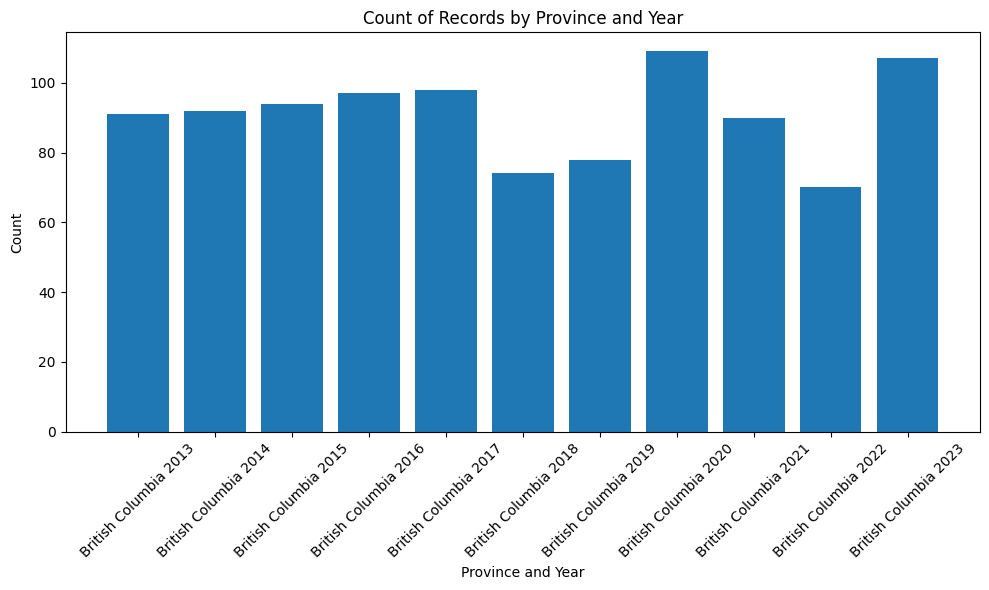

In [175]:
import matplotlib.pyplot as plt
graph = result_case.groupby(['ReportingProvince', 'Survey_Year']).size().reset_index(name='n')

plt.figure(figsize=(10, 6))
plt.bar(graph['ReportingProvince'] + ' ' + graph['Survey_Year'].astype(str), graph['n'])
plt.xlabel('Province and Year')
plt.ylabel('Count')
plt.title('Count of Records by Province and Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [176]:
casefinding_mapping = {
    1: '1-Symptoms or Incidental',
    2: '1-Symptoms or Incidental',
    5: '2-Immigration',
    5.1: '2-Immigration',
    5.2: '2-Immigration',
    4: '3-Contact Investigation',
    3: '4-Post mortem',
    7: '5-Occupational Screening',
    8: '6-Other screening',
    9: '7-Other Specify'
}

result_case['case_detection'] = result_case['CaseFinding'].map(casefinding_mapping)


For another example, we achieve the data points (they are going to be in different point of view) using two methods:   
We plot the number of cases of each detection method using a stackable bar graph and a line graph.  

##### Stackable Bar Graph

In [177]:
cross_tab = pd.crosstab(
    index=result_case['case_detection'],  # The index used for rows
    columns=result_case['Survey_Year'],     # The column names
    values=result_case['Subject_Status'] == 'Active',  # The value to aggregate with
    aggfunc='sum',                # Aggregation function to apply
    margins=False) 
    # margins_name='Total')



*Crosstab*: the [`crosstab`](https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html) method is used to create a cross tabulation to show the relation between the types of case_detection and the survey year using number of occurences of TB. The arguments are as follows:  
  
index=result_case['case_detection]: The index used for each row, here its the types of case_detection - Immigration, Post-mortem and so on.  
  
columns=result_case['Survey_Year']: The columns of the resultant tables - the years the survey was conducted.  
  
values=result_case['Subject_Status]=='Active': The values that are to be aggregated. Here, a boolean is returned based on if the current TB case is active or inactive.  
  
aggfunc='sum': The aggregate function to apply on the previous argument values. Here, the sum of all active tuberculosis cases is calculated (1 is added for all status == 'Active').  

In [178]:
cross_tab

Survey_Year,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
case_detection,,,,,,,,,,,
1-Symptoms or Incidental,23,22,19,24,24,20,24,18,21,21,29
2-Immigration,5,12,17,13,13,7,9,12,12,6,9
4-Post mortem,10,11,10,7,13,13,6,12,12,7,7
7-Other Specify,13,8,9,14,10,8,9,10,3,7,14


This dataframe can be transposed to form a dataframe with rows that denote the number of TB cases for each detection method in a year. This makes it easy to plot as a stackable bar graph below:

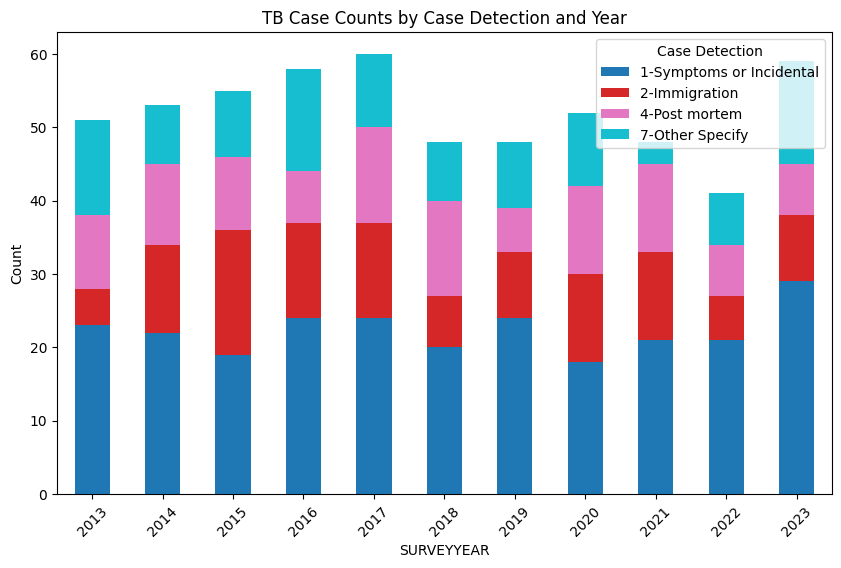

In [179]:
cross_tab.T.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='tab10')
plt.title('TB Case Counts by Case Detection and Year')
plt.xlabel('SURVEYYEAR')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Case Detection', loc='upper right')
plt.show()

`kind='bar'`: Specifies that you want to create a bar plot.  
`stacked=True`: Indicates that you want to create a stacked bar plot.  
`figsize=(10, 6)`: Sets the figure size to 10 units in width and 6 units in height.  
`cmap='tab10'`: Specifies the colormap for coloring the bars.  
  
`matplotlib` also lets us set labels for the axes as well customize ticks and its display.

#### Line chart

In [180]:
case_counts = result_case.groupby(['Survey_Year', 'case_detection']).size().reset_index(name='Number_of_Cases')

In the above sample, the dataframe is divided into groups where each group contains rows that have the same 'Survey_Year' and 'case_detection'. The returned grouped object can then be subjected to aggregate functions like mean, average and size (number of rows) in this instance.

In [181]:
case_counts.head(5)

,Survey_Year,case_detection,Number_of_Cases
0,2013,1-Symptoms or Incidental,23
1,2013,2-Immigration,5
2,2013,4-Post mortem,10
3,2013,7-Other Specify,13
4,2014,1-Symptoms or Incidental,22


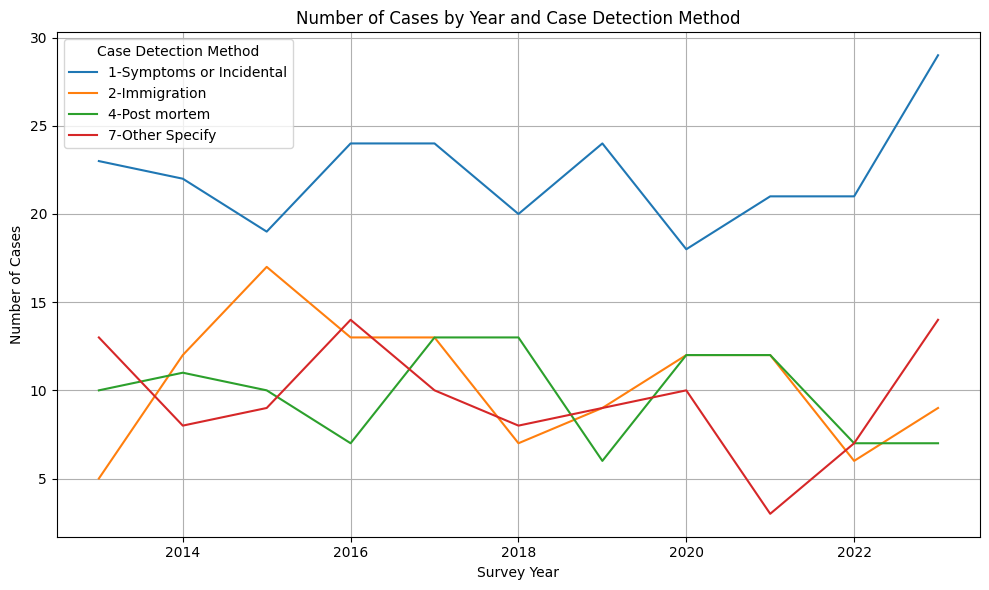

In [182]:

plt.figure(figsize=(10, 6))

for method in case_counts['case_detection'].unique():
    data = case_counts[case_counts['case_detection'] == method]
    plt.plot(data['Survey_Year'], data['Number_of_Cases'], label=method)

plt.xlabel('Survey Year')
plt.ylabel('Number of Cases')
plt.title('Number of Cases by Year and Case Detection Method')
plt.legend(title='Case Detection Method')
plt.grid(True)
plt.tight_layout()
plt.show()
